In [47]:
import pandas as pd
import os
import numpy as np
print("Current directory:", os.getcwd())
import sys
sys.path.append('.')
from MDQN import M_DQN_Agent
import torch
from collections import deque
from tqdm import tqdm
from Trading_Simulator import TradingEnvironment, pca_res_gen, fourier_signal_extractor, fourier_2timeframe

%reload_ext autoreload
%autoreload 2

Current directory: /Users/quintengeerts/Desktop/master thesis/stat_arb_thesis/empirical_analysis


In [41]:
import os
import datetime as dt
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[dt.datetime(1998,1,1):].dropna(axis=0, thresh=300)

In [13]:
action_to_portfolio = {0:-1, 1:0, 2: 1}

 Episode: 61 -- Annualized Return: 2.18% -- Annualized Volatility: 1.95% -- Annualized Sharpe: 1.12
 Episode: 61 -- Total ann. Return: 0.9% -- Total ann. Volatility: 2.57% -- Total ann. Sharpe: 0.35
Episode 62	Frame 6200 	Average Score: 0.00

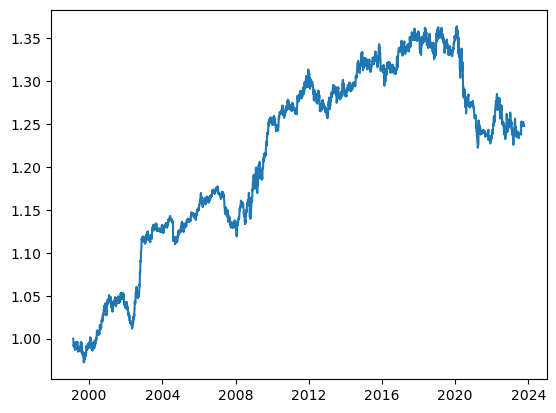

In [63]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PARAMETERS
seed = 200
#seed = np.random.randint(0,100000)

#writer = SummaryWriter("runs/"+"DQN_LL_new_1")
frames = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-2
eps_frames=5000
min_eps=0.025
LR = 1e-3
UPDATE_EVERY = 5
n_step = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
#env.seed(seed)
#nv.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# action_size     = env.action_space.n #### going to fix this
action_size       = 3
#state_size        = env.observation_space.shape
state_size        = [29]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=64,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################
action_to_portfolio = {0:-1, 1:0, 2: 1}
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=pca_res_gen,
                        signal_generator=fourier_signal_extractor,
                        episode_length=100,
                        lookback_window=252,
                        loading_window=60,
                        signal_window=30,
                        factors=5,
                        transaction_costs=0.0,
                        short_cost=0.0)

# env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
#                         residual_generator=pca_res_gen,
#                         signal_generator=fourier_2timeframe,
#                         episode_length=100,
#                         lookback_window=252,
#                         loading_window=60,
#                         signal_window=120,
#                         factors=5,
#                         transaction_costs=0.0,
#                         short_cost=0.0)

state, _ = env.warm_up()
state_vec= state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray

score = 1

for frame in range(1, frames+1):
    #print('\rcurrent frame: {} of {}, percentage: {}'.format(frame, frames, round(frame/frames*100)),end="")
    action = agent.act_para(state_vec, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    

    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            agent.step(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            agent.step(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)
    
    state     = next_state
    state_vec = next_state[env.tradeable_tickers].values.T

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % env.ep_N == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

In [73]:
env.total_pl.to_csv('results_pl.csv')

In [71]:
env.res_rets['BRK.B'].

date
2011-02-15   -0.001838
2011-02-16   -0.006864
2011-02-17   -0.002767
2011-02-18     -0.0011
2011-02-22   -0.001571
                ...   
2023-10-04   -0.003507
2023-10-05    0.005955
2023-10-06   -0.001845
2023-10-09   -0.010926
2023-10-10    0.004533
Name: BRK.B, Length: 3184, dtype: object

In [64]:
env.res_rets.to_csv('res_rets.csv')
env.res_alloc.to_csv('res_alloc.csv')

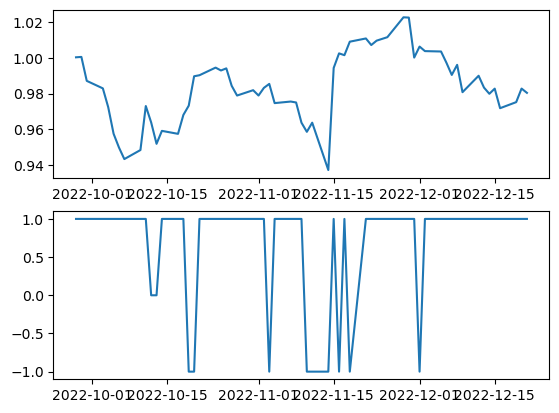

In [32]:
stock = 'WMT'
residual_test = (env.res_rets[stock].dropna().tail(60)+1).cumprod()
alloc_test    = env.res_alloc[stock].dropna().tail(60)
fig, ax  = plt.subplots(2,1)
ax[0].plot(residual_test)
ax[1].plot(alloc_test)

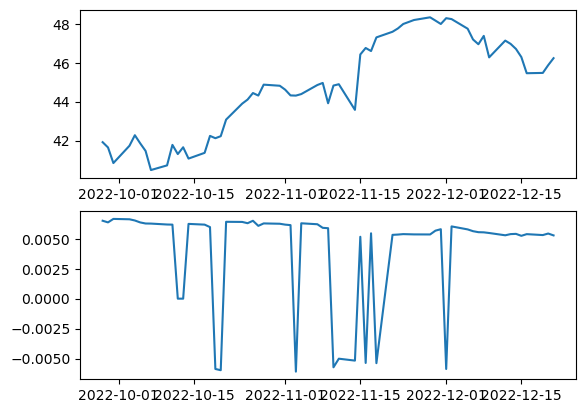

In [33]:
alloc_test    = env.asset_alloc[stock].dropna().tail(60)
residual_test = (env.data.loc[alloc_test.index,stock])
fig, ax  = plt.subplots(2,1)
ax[0].plot(residual_test)
ax[1].plot(alloc_test)